In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import traceback
import re
from pandas import Series
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import warnings
import os
import collections
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import string

**DATA WRANGLING**

TRAIN DATA FILE EXPLORATION:

In [2]:
train = pd.read_csv('train.csv')
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [4]:
train.duplicated().value_counts()

False    9693
True      813
dtype: int64

In [5]:
train.drop_duplicates(keep='first',inplace=True)

In [6]:
train.duplicated().value_counts()

False    9693
dtype: int64

In [7]:
train.groupby('AddressAccuracy')['Date'].count()

AddressAccuracy
3      89
5    1302
8    4522
9    3780
Name: Date, dtype: int64

In [8]:
percent = 89/(89+1302+4522+3780)
percent

0.009181883833694419

In [9]:
train['Date'] = pd.to_datetime(train['Date'], format= '%Y/%m/%d')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    9693 non-null   datetime64[ns]
 1   Address                 9693 non-null   object        
 2   Species                 9693 non-null   object        
 3   Block                   9693 non-null   int64         
 4   Street                  9693 non-null   object        
 5   Trap                    9693 non-null   object        
 6   AddressNumberAndStreet  9693 non-null   object        
 7   Latitude                9693 non-null   float64       
 8   Longitude               9693 non-null   float64       
 9   AddressAccuracy         9693 non-null   int64         
 10  NumMosquitos            9693 non-null   int64         
 11  WnvPresent              9693 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4), obj

SPRAY DATA FILE EXPLORATION:

In [11]:
spray = pd.read_csv('spray.csv')
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [12]:
missing = pd.concat([spray.isnull().sum(), 100 * spray.isnull().mean()], axis=1)
header = missing.columns=['count', '%']
missing.sort_values(by=header, ascending=False)
#There are 584 missing values for time, which makes up 4% of the data.

,count,%
Time,584,3.936636
Date,0,0.000000
Latitude,0,0.000000
Longitude,0,0.000000


In [13]:
spray['Time'].sort_values().isnull()

8512     False
6731     False
11272    False
4702     False
11904    False
         ...  
1609      True
1610      True
1611      True
1612      True
1613      True
Name: Time, Length: 14835, dtype: bool

In [14]:
spray.iloc[1590:1613]

,Date,Time,Latitude,Longitude
1590,2011-09-07,NaN,41.992612,-87.813343
1591,2011-09-07,NaN,41.992660,-87.812767
1592,2011-09-07,NaN,41.992660,-87.812191
1593,2011-09-07,NaN,41.992612,-87.811663
1594,2011-09-07,NaN,41.992660,-87.811279
1595,2011-09-07,NaN,41.992660,-87.810847
1596,2011-09-07,NaN,41.992612,-87.810415
1597,2011-09-07,NaN,41.992660,-87.809455
1598,2011-09-07,NaN,41.992660,-87.809983
1599,2011-09-07,NaN,41.992708,-87.808927


Analysis: The Time Column had a few null values. Performed analysis to see what percent of the data was null. Only 4% of the data contained null values. It looks like all values are related to 2011-09-07. 

Observation: Perhaps we could concatenate the date and time columns to form a datetime datatype. 

In [15]:
spray['Date_Time'] = spray['Date'] + " " + spray['Time']
spray.head()

,Date,Time,Latitude,Longitude,Date_Time
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011-08-29 6:56:58 PM
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011-08-29 6:57:08 PM
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011-08-29 6:57:18 PM
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011-08-29 6:57:28 PM
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011-08-29 6:57:38 PM


In [16]:
spray['Date_Time'].value_counts().head(10)

2011-09-07 7:44:32 PM    541
2013-08-29 9:21:53 PM      2
2013-08-29 8:48:23 PM      2
2013-07-17 8:16:37 PM      2
2013-07-17 9:09:17 PM      2
2013-08-29 9:30:43 PM      2
2013-07-17 8:54:37 PM      2
2013-07-25 8:56:16 PM      2
2013-08-29 9:26:53 PM      2
2013-07-17 8:22:07 PM      2
Name: Date_Time, dtype: int64

Further analyzing the data to see if there are any anomalies. There are 541 rows that appear to be related to the same date as mentioned for the missing values (2011-09-07). Something funny is happening with this day. Could be related. However, in this case they appear to be duplicates.

In [17]:
spray['Lat_Lon'] = spray['Latitude'].astype(str) + ','+ spray['Longitude'].astype(str)
spray.head()
spray['Lat_Lon'].value_counts().sort_values(ascending=False).head(10)

41.98646,-87.794225                      541
41.9839166666667,-87.7930883333333         2
41.722553333333295,-87.64814               1
41.9900966666667,-87.6732266666667         1
42.3929583333333,-88.0903                  1
41.963573333333294,-87.77839499999999      1
41.979521666666706,-87.68625               1
41.9950603390456,-87.8181913228049         1
41.73424,-87.63535999999999                1
41.957525,-87.7223616666667                1
Name: Lat_Lon, dtype: int64

In [18]:
spray.duplicated().value_counts()

False    14294
True       541
dtype: int64

Confirmed they are duplicates. I also decided to drop the null values since they relate to the same day. I'd rather lose a day of data that is questionable rather than keeping it.

In [19]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
 4   Date_Time  14251 non-null  object 
 5   Lat_Lon    14835 non-null  object 
dtypes: float64(2), object(4)
memory usage: 695.5+ KB


In [20]:
spray.drop_duplicates(keep='first',inplace=True)

In [21]:
spray.duplicated().value_counts()

False    14294
dtype: int64

In [22]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14294 entries, 0 to 14834
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14294 non-null  object 
 1   Time       13710 non-null  object 
 2   Latitude   14294 non-null  float64
 3   Longitude  14294 non-null  float64
 4   Date_Time  13710 non-null  object 
 5   Lat_Lon    14294 non-null  object 
dtypes: float64(2), object(4)
memory usage: 781.7+ KB


C:\Users\mayra\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


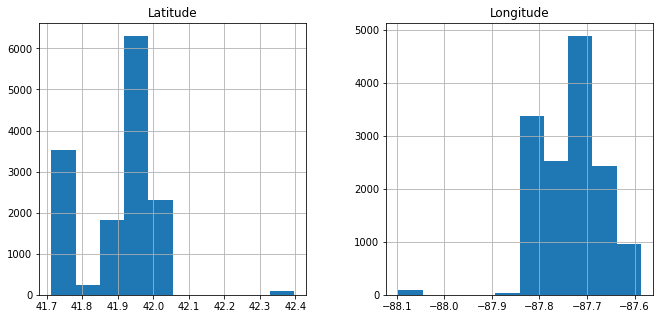

In [23]:
spray.hist(figsize=(11,5))
plt.subplots_adjust(hspace=0.5);

In [24]:
spray.dropna(inplace=True)

In [25]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13710 entries, 0 to 14834
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       13710 non-null  object 
 1   Time       13710 non-null  object 
 2   Latitude   13710 non-null  float64
 3   Longitude  13710 non-null  float64
 4   Date_Time  13710 non-null  object 
 5   Lat_Lon    13710 non-null  object 
dtypes: float64(2), object(4)
memory usage: 749.8+ KB


C:\Users\mayra\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


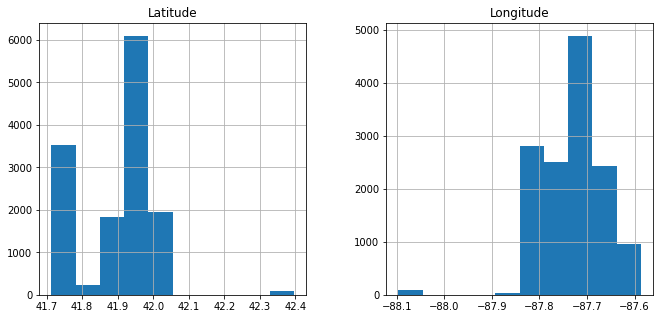

In [26]:
spray.hist(figsize=(11,5))
plt.subplots_adjust(hspace=0.5);

In [27]:
missing = pd.concat([spray.isnull().sum(), 100 * spray.isnull().mean()], axis=1)
header = missing.columns=['count', '%']
missing.sort_values(by=header, ascending=False)

,count,%
Date,0,0.0
Time,0,0.0
Latitude,0,0.0
Longitude,0,0.0
Date_Time,0,0.0
Lat_Lon,0,0.0


Summary of analysis on Spray data file:

Noticed there were 584 values that were null, which make-up 4% of the data. Also found there were 541 duplicates. All of these findings were related to the same date, which made me question the data for that day. I'm certain that dropping the duplicates was correct, and made a choice to drop the null values (due to uncertainty of the validity of the data for that day).

WEATHER DATA FILE EXPLORATION:

In [28]:
weather = pd.read_csv('weather.csv')
weather.head().T

,0,1,2,3,4
Station,1,2,1,2,1
Date,2007-05-01,2007-05-01,2007-05-02,2007-05-02,2007-05-03
Tmax,83,84,59,60,66
Tmin,50,52,42,43,46
Tavg,67,68,51,52,56
Depart,14,M,-3,M,2
DewPoint,51,51,42,42,40
WetBulb,56,57,47,47,48
Heat,0,0,14,13,9
Cool,2,3,0,0,0


In [29]:
weather.sort_values(by='WetBulb',ascending=False)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2410,1,2013-08-10,81,64,73,0,57,M,0,8,...,,0,M,0.0,0.00,M,30.08,5.3,5,6.5
2412,1,2013-08-11,81,60,71,-2,61,M,0,6,...,RA,0,M,0.0,0.01,29.35,30.07,2.0,27,3.0
848,1,2009-06-26,86,69,78,7,60,M,0,13,...,,0,M,0.0,0.00,M,29.85,6.4,4,8.2
2415,2,2013-08-12,85,69,77,M,63,M,0,12,...,RA,M,M,M,0.66,29.27,29.92,4.5,26,7.7
1628,1,2011-07-18,92,80,86,12,75,78,0,21,...,RA HZ,0,M,0.0,0.01,29.23,29.96,10.6,25,10.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,1,2008-10-28,45,31,38,-9,23,33,27,0,...,,0,M,0.0,0.00,29.54,30.29,10.5,30,10.9
729,2,2008-10-28,45,32,39,M,23,33,26,0,...,,M,M,M,0.00,29.60,30.31,9.9,30,10.3
1063,2,2009-10-11,45,29,37,M,23,33,28,0,...,,M,M,M,0.00,29.67,30.36,1.1,1,4.8
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


It looks like there are some columns that contain 'M' and determined, per the data overview on Kaggle, that these were representing 'Missing information'. Therefore, I will replace these values as needed.

C:\Users\mayra\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


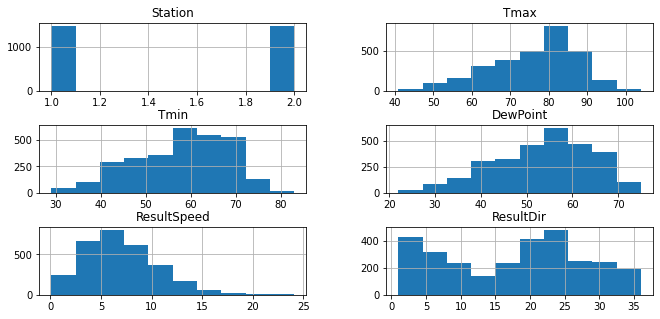

In [30]:
weather.hist(figsize=(11,5))
plt.subplots_adjust(hspace=0.5);

In [31]:
weather.duplicated().value_counts()

False    2944
dtype: int64

In [32]:
Tavg = len(weather[weather['Tavg'].str.contains('M')])
print(Tavg)

11


In [33]:
Depart = len(weather[weather['Depart'].str.contains('M')])
print(Depart)


1472


In [34]:
weather['Depart'].describe()

count     2944
unique      42
top          M
freq      1472
Name: Depart, dtype: object

In [35]:
weather['Depart'].unique()

array(['14', 'M', '-3', ' 2', ' 4', ' 5', '10', '12', '13', '-2', '15',
       '11', '-4', '-6', ' 8', '-5', ' 1', ' 9', ' 6', '-9', '-8', ' 3',
       ' 0', '-1', '-7', ' 7', '-14', '18', '16', '22', '21', '20', '-10',
       '-16', '17', '-12', '-11', '-15', '-17', '19', '-13', '23'],
      dtype=object)

In [36]:
WetBulb = len(weather[weather['WetBulb'].str.contains('M')])
print(WetBulb)

4


In [37]:
Heat = len(weather[weather['Heat'].str.contains('M')])
print(Heat)

11


In [38]:
Cool = len(weather[weather['Cool'].str.contains('M')])
print(Cool)

11


In [39]:
Sunrise = len(weather[weather['Sunrise'].str.contains('-')])
print(Sunrise)

1472


In [40]:
Sunset = len(weather[weather['Sunset'].str.contains('-')])
print(Sunset)

1472


In [41]:
#forcing those with 'M' or '-' to be null values
weather['Tavg']= pd.to_numeric(weather['Tavg'], errors='coerce')
weather['WetBulb']= pd.to_numeric(weather['WetBulb'], errors='coerce')
weather['Heat']= pd.to_numeric(weather['Heat'], errors='coerce')
weather['Cool']= pd.to_numeric(weather['Cool'], errors='coerce')
weather['SnowFall']= pd.to_numeric(weather['SnowFall'], errors='coerce')
weather['PrecipTotal']= pd.to_numeric(weather['PrecipTotal'], errors='coerce')
weather['StnPressure']= pd.to_numeric(weather['StnPressure'], errors='coerce')
weather['SeaLevel']= pd.to_numeric(weather['SeaLevel'], errors='coerce')
weather['AvgSpeed']= pd.to_numeric(weather['AvgSpeed'], errors='coerce')
weather['Depart']= pd.to_numeric(weather['Depart'], errors='coerce')
weather['Sunrise']= pd.to_numeric(weather['Sunrise'], errors='coerce')
weather['Sunset']= pd.to_numeric(weather['Sunset'], errors='coerce')

In [42]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2933 non-null   float64
 5   Depart       1472 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2940 non-null   float64
 8   Heat         2933 non-null   float64
 9   Cool         2933 non-null   float64
 10  Sunrise      1472 non-null   float64
 11  Sunset       1472 non-null   float64
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     1460 non-null   float64
 16  PrecipTotal  2624 non-null   float64
 17  StnPressure  2940 non-null   float64
 18  SeaLevel     2935 non-null   float64
 19  Result

In [43]:
#decided to use the average of Tmax and Tmin to be consistent with the other values that are in place
weather['Tavg'].fillna((weather['Tmax']+weather['Tmin'])/2,inplace=True)
weather.sort_values(by='Tavg',ascending=False).tail(5)   

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2560,1,2013-10-24,44,31,38.0,-11.0,25,33.0,27.0,0.0,...,,0,M,NaN,NaN,29.45,30.16,10.3,30,10.9
1063,2,2009-10-11,45,29,37.0,NaN,23,33.0,28.0,0.0,...,,M,M,NaN,0.00,29.67,30.36,1.1,1,4.8
1062,1,2009-10-11,44,29,37.0,-17.0,22,32.0,28.0,0.0,...,,0,M,0.0,0.00,29.60,30.35,1.5,33,5.0
2557,2,2013-10-22,41,31,36.0,NaN,31,35.0,29.0,0.0,...,RA DZ BR,M,M,NaN,0.03,29.28,29.97,4.6,26,5.4
2556,1,2013-10-22,42,29,36.0,-14.0,31,34.0,29.0,0.0,...,RA,0,M,NaN,NaN,29.21,29.95,5.4,26,6.1


In [44]:
weather['WetBulb'].fillna(weather['WetBulb'].median(),inplace=True)
#weather.sort_values(by='WetBulb',ascending=False).tail(5)    

In [45]:
weather['Heat'].fillna(weather['Heat'].median(),inplace=True)
#weather.sort_values(by='Heat',ascending=False).tail(5)

In [46]:
weather['Cool'].fillna(weather['Cool'].median(),inplace=True)
#weather.sort_values(by='Cool',ascending=False).tail(5)

In [47]:
weather['SnowFall'].fillna(weather['SnowFall'].median(),inplace=True)
#weather.sort_values(by='SnowFall',ascending=False).tail(5)

In [48]:
weather['PrecipTotal'].fillna(weather['PrecipTotal'].median(),inplace=True)
#weather.sort_values(by='PrecipTotal',ascending=False).tail(5)

In [49]:
weather['StnPressure'].fillna(weather['StnPressure'].median(),inplace=True)
#weather.sort_values(by='StnPressure',ascending=False).tail(5)

In [50]:
weather['SeaLevel'].fillna(weather['SeaLevel'].median(),inplace=True)
#weather.sort_values(by='SeaLevel',ascending=False).tail(5)

In [51]:
weather['AvgSpeed'].fillna(weather['AvgSpeed'].median(),inplace=True)

In [52]:
#decided to fill with the same values as Station 1 - as it will be closer to reality, rather than using average or median
weather['Depart'].fillna(method='ffill',inplace=True)
weather['Sunrise'].fillna(method='ffill',inplace=True)
weather['Sunset'].fillna(method='ffill',inplace=True)

In [53]:
weather['Depart'].head()

0    14.0
1    14.0
2    -3.0
3    -3.0
4     2.0
Name: Depart, dtype: float64

In [54]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,14.0,51,57.0,0.0,3.0,...,,M,M,0.0,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,-3.0,42,47.0,13.0,0.0,...,BR HZ,M,M,0.0,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9


In [55]:
del weather['Water1']

In [56]:
del weather['Depth']

In [57]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   float64
 5   Depart       2944 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   float64
 8   Heat         2944 non-null   float64
 9   Cool         2944 non-null   float64
 10  Sunrise      2944 non-null   float64
 11  Sunset       2944 non-null   float64
 12  CodeSum      2944 non-null   object 
 13  SnowFall     2944 non-null   float64
 14  PrecipTotal  2944 non-null   float64
 15  StnPressure  2944 non-null   float64
 16  SeaLevel     2944 non-null   float64
 17  ResultSpeed  2944 non-null   float64
 18  ResultDir    2944 non-null   int64  
 19  AvgSpe

Summary of analysis on Weather data file:

The 'weather' dataset didn't appear to have duplicates or null values. However, it does have a lot of 'M' values where, perhaps, it shouldn't. Need guidance on how to handle.

**EXPLORATORY DATA ANALYSIS**

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    9693 non-null   datetime64[ns]
 1   Address                 9693 non-null   object        
 2   Species                 9693 non-null   object        
 3   Block                   9693 non-null   int64         
 4   Street                  9693 non-null   object        
 5   Trap                    9693 non-null   object        
 6   AddressNumberAndStreet  9693 non-null   object        
 7   Latitude                9693 non-null   float64       
 8   Longitude               9693 non-null   float64       
 9   AddressAccuracy         9693 non-null   int64         
 10  NumMosquitos            9693 non-null   int64         
 11  WnvPresent              9693 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4), obj

In [59]:
train.nunique()

Date                       95
Address                   138
Species                     7
Block                      64
Street                    128
Trap                      136
AddressNumberAndStreet    138
Latitude                  138
Longitude                 138
AddressAccuracy             4
NumMosquitos               50
WnvPresent                  2
dtype: int64

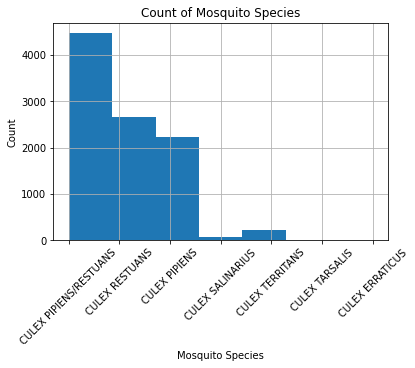

In [60]:
train.Species.hist(bins=7)
plt.xticks(rotation=45)
plt.title('Count of Mosquito Species')
plt.xlabel('Mosquito Species')
plt.ylabel('Count');

[Text(0.5, 1.0, 'West Nile Virus Presence')]

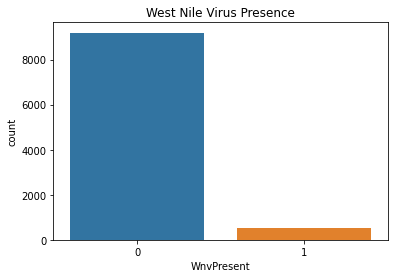

In [61]:
sns.countplot(data = train, x = 'WnvPresent').set(title='West Nile Virus Presence') 

[Text(0.5, 1.0, 'Presence of Virus by Species')]

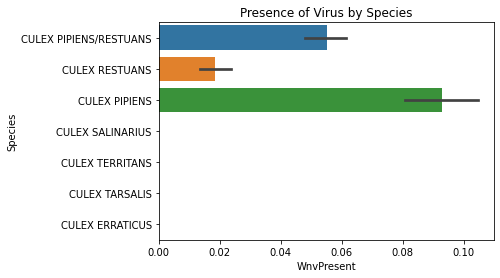

In [62]:
sns.barplot(data = train
            ,x = 'WnvPresent'
            ,y = 'Species'
            ).set(title='Presence of Virus by Species')

<AxesSubplot:xlabel='Species', ylabel='WnvPresent'>

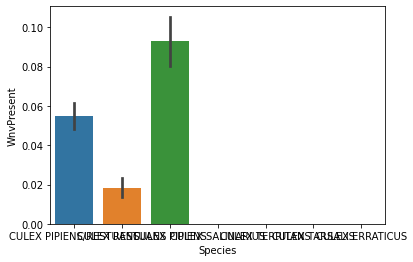

In [63]:
sns.barplot(data = train
            ,x = 'Species'
            ,y = 'WnvPresent'
            )

In [64]:
weather.nunique()

Station           2
Date           1472
Tmax             63
Tmin             54
Tavg             66
Depart           41
DewPoint         54
WetBulb          47
Heat             30
Cool             30
Sunrise         121
Sunset          118
CodeSum          98
SnowFall          2
PrecipTotal     166
StnPressure     103
SeaLevel        101
ResultSpeed     190
ResultDir        36
AvgSpeed        177
dtype: int64

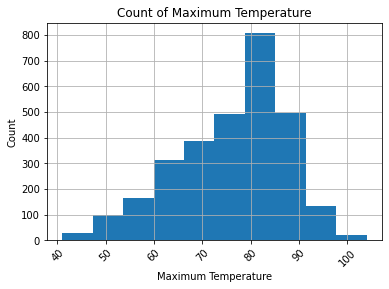

In [65]:
weather.Tmax.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of Maximum Temperature')
plt.xlabel('Maximum Temperature')
plt.ylabel('Count');

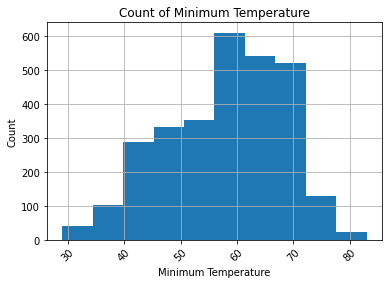

In [66]:
weather.Tmin.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of Minimum Temperature')
plt.xlabel('Minimum Temperature')
plt.ylabel('Count');

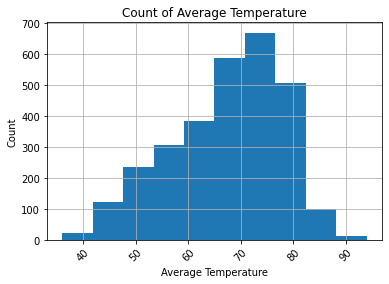

In [67]:
weather.Tavg.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Count');

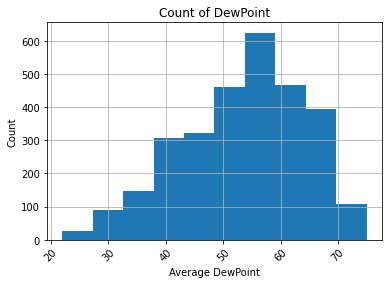

In [68]:
weather.DewPoint.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of DewPoint')
plt.xlabel('Average DewPoint')
plt.ylabel('Count');

In [69]:
weather.mode().head(1)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1.0,2007-05-01,84.0,63.0,73.0,2.0,59.0,63.0,0.0,0.0,416.0,1931.0,,0.0,0.0,29.28,30.0,5.9,21.0,6.9


In [70]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   float64
 5   Depart       2944 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   float64
 8   Heat         2944 non-null   float64
 9   Cool         2944 non-null   float64
 10  Sunrise      2944 non-null   float64
 11  Sunset       2944 non-null   float64
 12  CodeSum      2944 non-null   object 
 13  SnowFall     2944 non-null   float64
 14  PrecipTotal  2944 non-null   float64
 15  StnPressure  2944 non-null   float64
 16  SeaLevel     2944 non-null   float64
 17  ResultSpeed  2944 non-null   float64
 18  ResultDir    2944 non-null   int64  
 19  AvgSpe

In [71]:
weather['Date'] = pd.to_datetime(weather['Date'], format= '%Y/%m/%d')

In [72]:
weather_scale = weather.loc[:,['Station','Date','Tmax','Tmin','Tavg','Depart','DewPoint','WetBulb','Heat','Cool','Sunrise','Sunset','SnowFall','PrecipTotal','StnPressure','SeaLevel','ResultSpeed','ResultDir','AvgSpeed']]

In [73]:
weather_scale = weather_scale.set_index('Date')
weather_index = weather_scale.index
weather_columns = weather_scale.columns
weather_scale.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68.0,14.0,51,57.0,0.0,3.0,448.0,1849.0,0.0,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52.0,-3.0,42,47.0,13.0,0.0,447.0,1850.0,0.0,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,0.0,0.0,29.39,30.12,11.7,7,11.9


In [74]:
weather_scale.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68.0,14.0,51,57.0,0.0,3.0,448.0,1849.0,0.0,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52.0,-3.0,42,47.0,13.0,0.0,447.0,1850.0,0.0,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,0.0,0.0,29.39,30.12,11.7,7,11.9


In [75]:
weather_scale = scale(weather_scale)

In [76]:
weather_scaled_df = pd.DataFrame(weather_scale, columns=weather_columns)
weather_scaled_df.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,-1.0,0.596325,-0.752440,-0.022710,1.761353,-0.230282,-0.357060,-0.570990,-0.597520,-0.499778,0.018986,-0.018433,-0.333823,-1.164219,-0.935627,-1.466626,0.944662,0.197139
1,1.0,0.683585,-0.559765,0.072193,1.761353,-0.230282,-0.249290,-0.570990,-0.433410,-0.499778,0.018986,-0.018433,-0.333823,-0.659197,-0.935627,-1.187835,0.745892,0.324317
2,-1.0,-1.497912,-1.523140,-1.541170,-0.724468,-1.073502,-1.326986,1.784051,-0.925741,-0.515086,0.030477,-0.018433,-0.333823,0.603359,0.769703,1.683711,-1.341189,1.532508
3,1.0,-1.410652,-1.426803,-1.446266,-0.724468,-1.073502,-1.326986,1.615834,-0.925741,-0.515086,0.030477,-0.018433,-0.333823,0.982126,0.706542,1.767349,-1.539958,1.532508
4,-1.0,-0.887093,-1.137790,-1.066651,0.006656,-1.260884,-1.219216,0.942965,-0.925741,-0.530395,0.041969,-0.018433,-0.333823,0.666487,0.959184,1.321283,-1.043034,1.055590


In [77]:
weather_scaled_df.mean()

Station        0.000000e+00
Tmax          -4.973377e-16
Tmin          -2.965623e-16
Tavg           4.698838e-16
Depart        -1.748300e-16
DewPoint      -5.430439e-18
WetBulb       -1.976076e-17
Heat          -9.610368e-16
Cool           4.868539e-16
Sunrise       -6.208802e-16
Sunset        -2.304920e-16
SnowFall      -7.135912e-16
PrecipTotal   -7.523420e-18
StnPressure    1.420414e-14
SeaLevel      -5.736655e-15
ResultSpeed    3.016910e-19
ResultDir      1.116257e-17
AvgSpeed       4.857226e-16
dtype: float64

In [78]:
weather_scaled_df.std()

Station        1.00017
Tmax           1.00017
Tmin           1.00017
Tavg           1.00017
Depart         1.00017
DewPoint       1.00017
WetBulb        1.00017
Heat           1.00017
Cool           1.00017
Sunrise        1.00017
Sunset         1.00017
SnowFall       1.00017
PrecipTotal    1.00017
StnPressure    1.00017
SeaLevel       1.00017
ResultSpeed    1.00017
ResultDir      1.00017
AvgSpeed       1.00017
dtype: float64

In [79]:
weather_scaled_df.std(ddof=0)

Station        1.0
Tmax           1.0
Tmin           1.0
Tavg           1.0
Depart         1.0
DewPoint       1.0
WetBulb        1.0
Heat           1.0
Cool           1.0
Sunrise        1.0
Sunset         1.0
SnowFall       1.0
PrecipTotal    1.0
StnPressure    1.0
SeaLevel       1.0
ResultSpeed    1.0
ResultDir      1.0
AvgSpeed       1.0
dtype: float64

In [80]:
weather_pca = PCA().fit(weather_scale)

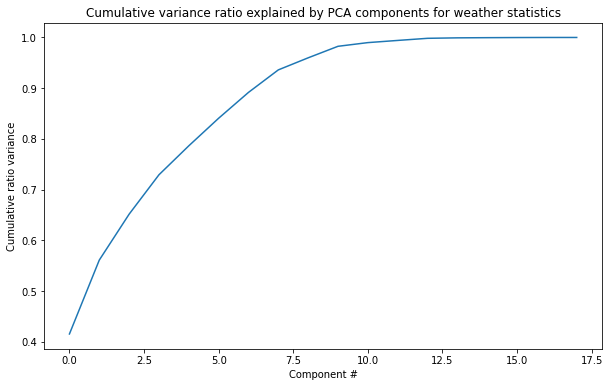

In [81]:
plt.subplots(figsize=(10, 6))
plt.plot(weather_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for weather statistics');

In [82]:
weather_pca_x = weather_pca.transform(weather_scale)

In [83]:
weather_pca_x.shape

(2944, 18)

In [84]:
pca_df = pd.DataFrame({'PC1': weather_pca_x[:, 0], 'PC2': weather_pca_x[:, 1]}, index=weather_index) #QUESTION: Why can't we just use the x and y variables that were assigned to this originally?
pca_df.head()

,PC1,PC2
Date,,
2007-05-01,-0.553033,0.761036
2007-05-01,-0.721652,0.529628
2007-05-02,3.724187,0.760775
2007-05-02,3.584352,0.459738
2007-05-03,2.777731,0.261173


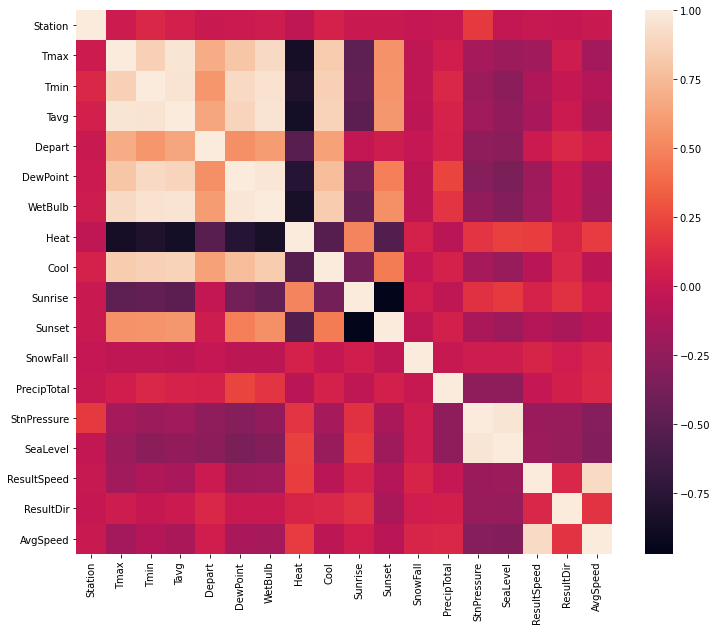

In [85]:
plt.subplots(figsize=(12,10))
sns.heatmap(weather.corr());

In [86]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Tmax', data=weather, alpha=0.5)
        ax.set(xlabel=col, ylabel='Max Temp')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [87]:
features = [item for item in weather.columns if item not in ['Date','ResultDir', 'AvgSpeed', 'ResultSPeed','CodeSum']]


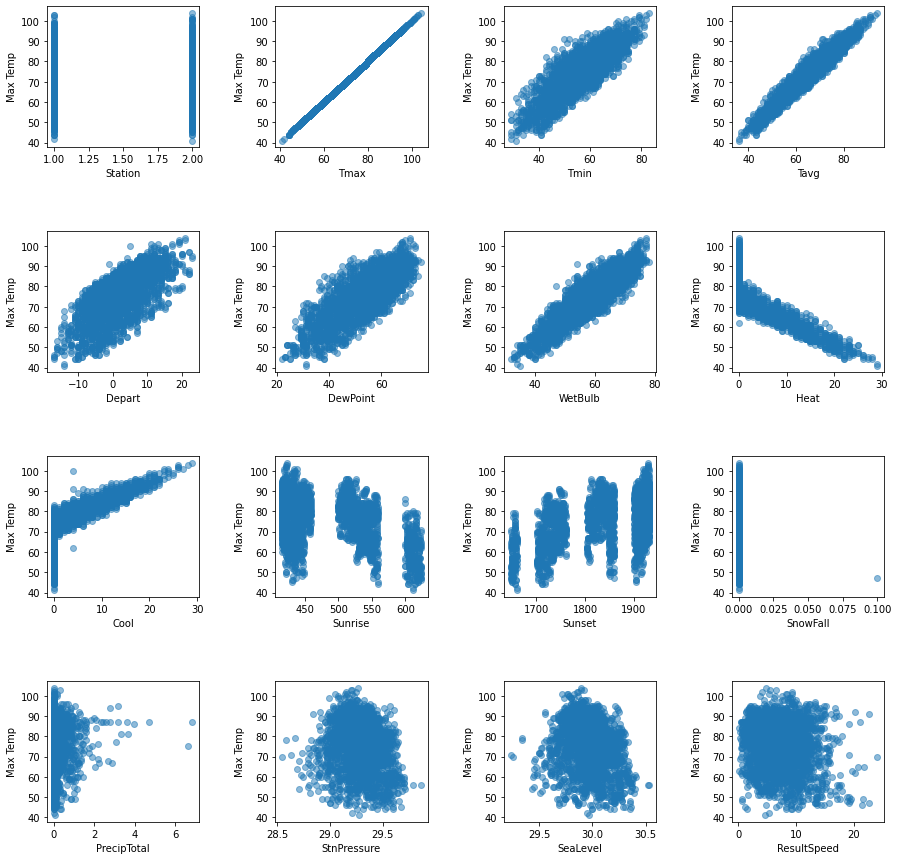

In [88]:
scatterplots(features, ncol=4, figsize=(15, 15))

In [89]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [90]:
#This is to test if the haversine function is working. Which appears to do so.
test_function = haversine(-87.800991,41.95469,-87.824812,41.974089)
test_function


2.9209549484622293

In [91]:
#This is to add the Lat/Lon columns to the 'weather' Dataframe for each station.
weather['Latitude'] = np.where(weather['Station'] ==1, 41.995 , 41.786)
weather['Longitude'] = np.where(weather['Station'] ==1,  -87.933 , -87.752)
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Latitude,Longitude
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,,0.0,0.0,29.10,29.82,1.7,27,9.2,41.995,-87.933
1,2,2007-05-01,84,52,68.0,14.0,51,57.0,0.0,3.0,...,,0.0,0.0,29.18,29.82,2.7,25,9.6,41.786,-87.752
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,BR,0.0,0.0,29.38,30.09,13.0,4,13.4,41.995,-87.933
3,2,2007-05-02,60,43,52.0,-3.0,42,47.0,13.0,0.0,...,BR HZ,0.0,0.0,29.44,30.08,13.3,2,13.4,41.786,-87.752
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,,0.0,0.0,29.39,30.12,11.7,7,11.9,41.995,-87.933


In [92]:
merged_train = train.merge(weather, on='Date')
merged_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Latitude_y,Longitude_y
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0.0,0.0,29.44,30.09,5.8,16,7.4,41.786,-87.752
2,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
3,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0.0,0.0,29.44,30.09,5.8,16,7.4,41.786,-87.752
4,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933


In [93]:
merged_train.shape

(19386, 33)

In [94]:
merged_train['LatDif'] = abs(merged_train['Latitude_x'] - merged_train['Latitude_y'])
merged_train['LonDif'] = abs(merged_train['Longitude_x'] - merged_train['Longitude_y'])
merged_train['CoorAvg'] = (merged_train['LatDif'] + merged_train['LonDif'])/2
merged_train.head(10)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Latitude_y,Longitude_y,LatDif,LonDif,CoorAvg
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,29.39,30.11,5.8,18,6.5,41.995,-87.933,0.040310,0.132009,0.086160
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.168690,0.048991,0.108840
2,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,29.39,30.11,5.8,18,6.5,41.995,-87.933,0.040310,0.132009,0.086160
3,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.168690,0.048991,0.108840
4,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,29.39,30.11,5.8,18,6.5,41.995,-87.933,0.000009,0.163721,0.081865
5,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.208991,0.017279,0.113135
6,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,29.39,30.11,5.8,18,6.5,41.995,-87.933,0.020911,0.108188,0.064550
7,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.188089,0.072812,0.130450
8,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,29.39,30.11,5.8,18,6.5,41.995,-87.933,0.020911,0.108188,0.064550
9,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.188089,0.072812,0.130450


In [95]:
merged_train.shape

(19386, 36)

In [96]:
del merged_train['SnowFall']

In [97]:
merged_train = merged_train.sort_values(by = 'CoorAvg')
merged_train = merged_train.drop_duplicates(['Date', 'Address', 'Trap', 'Latitude_x', 'Longitude_x'], keep='first')

In [98]:
merged_train.shape

(4616, 35)

In [99]:
merged_train.sort_values(by = 'Date').head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Latitude_y,Longitude_y,LatDif,LonDif,CoorAvg
6,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,29.39,30.11,5.8,18,6.5,41.995,-87.933,0.020911,0.108188,0.064550
33,2007-05-29,"1700 West 95th Street, Chicago, IL 60643, USA",CULEX RESTUANS,17,W 95TH ST,T094,"1700 W 95TH ST, Chicago, IL",41.720848,-87.666014,9,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.065152,0.085986,0.075569
17,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.081108,0.097776,0.089442
47,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.121645,0.008886,0.065266
31,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,...,29.44,30.09,5.8,16,7.4,41.786,-87.752,0.076292,0.103140,0.089716


**FEATURE ENGINEERING**

In [100]:
#Formula for relative humidity at https://www.wikihow.com/Calculate-Humidity

def relative_humidity(Tavg,DewPoint):
    Tavg_C= (Tavg-32) * 5/9
    DewPoint_C = (DewPoint -32) * 5/9
    sat_vapor_pressure = 6.11*10**(7.5*Tavg_C/(237.7+Tavg_C))
    actual_pressure= 6.11*10**(7.5*DewPoint_C/(237.7+DewPoint_C))
    
    return round(((actual_pressure/sat_vapor_pressure)*100),2)

merged_train['Relative_Humidity'] = relative_humidity(merged_train['Tavg'],merged_train['DewPoint'])
merged_train.head().T


,15963,11349,12551,19083,12231
Date,2013-07-12 00:00:00,2011-06-30 00:00:00,2011-07-29 00:00:00,2013-09-19 00:00:00,2011-07-25 00:00:00
Address,"Chicago Midway International Airport (MDW), 52...","Chicago Midway International Airport (MDW), 52...","Chicago Midway International Airport (MDW), 52...","Chicago Midway International Airport (MDW), 52...","Chicago Midway International Airport (MDW), 52..."
Species,CULEX RESTUANS,CULEX RESTUANS,CULEX RESTUANS,CULEX PIPIENS,CULEX PIPIENS
Block,52,52,52,52,52
Street,W 63RD ST,W 63RD ST,W 63RD ST,W 63RD ST,W 63RD ST
Trap,T065,T065,T065,T065,T065
AddressNumberAndStreet,"5200 W 63RD ST, Chicago, IL","5200 W 63RD ST, Chicago, IL","5200 W 63RD ST, Chicago, IL","5200 W 63RD ST, Chicago, IL","5200 W 63RD ST, Chicago, IL"
Latitude_x,41.7783,41.7783,41.7783,41.7783,41.7783
Longitude_x,-87.7524,-87.7524,-87.7524,-87.7524,-87.7524
AddressAccuracy,9,9,9,9,9


In [101]:
merged_train['SpeciesDummy'] = merged_train['Species']
new_df = pd.get_dummies(merged_train, columns=['SpeciesDummy'])

new_df.head().T

,15963,11349,12551,19083,12231
Date,2013-07-12 00:00:00,2011-06-30 00:00:00,2011-07-29 00:00:00,2013-09-19 00:00:00,2011-07-25 00:00:00
Address,"Chicago Midway International Airport (MDW), 52...","Chicago Midway International Airport (MDW), 52...","Chicago Midway International Airport (MDW), 52...","Chicago Midway International Airport (MDW), 52...","Chicago Midway International Airport (MDW), 52..."
Species,CULEX RESTUANS,CULEX RESTUANS,CULEX RESTUANS,CULEX PIPIENS,CULEX PIPIENS
Block,52,52,52,52,52
Street,W 63RD ST,W 63RD ST,W 63RD ST,W 63RD ST,W 63RD ST
Trap,T065,T065,T065,T065,T065
AddressNumberAndStreet,"5200 W 63RD ST, Chicago, IL","5200 W 63RD ST, Chicago, IL","5200 W 63RD ST, Chicago, IL","5200 W 63RD ST, Chicago, IL","5200 W 63RD ST, Chicago, IL"
Latitude_x,41.7783,41.7783,41.7783,41.7783,41.7783
Longitude_x,-87.7524,-87.7524,-87.7524,-87.7524,-87.7524
AddressAccuracy,9,9,9,9,9


In [102]:
table1 = pd.pivot_table(merged_train, values='NumMosquitos', index=['Species'],
                    columns=['WnvPresent'], aggfunc=np.sum)
table1

WnvPresent,0,1
Species,,
CULEX PIPIENS,6529.0,1620.0
CULEX PIPIENS/RESTUANS,18491.0,2039.0
CULEX RESTUANS,6721.0,156.0
CULEX SALINARIUS,41.0,NaN
CULEX TARSALIS,2.0,NaN
CULEX TERRITANS,129.0,NaN


In [103]:
table2 = pd.pivot_table(new_df, index=['WnvPresent'],
                    values=['Tmax','Tavg','Tmin','Relative_Humidity','DewPoint','WetBulb'], aggfunc=np.mean)
table2

,DewPoint,Relative_Humidity,Tavg,Tmax,Tmin,WetBulb
WnvPresent,,,,,,
0,58.759891,63.275202,72.232874,80.884920,63.121863,63.994800
1,61.160622,63.799223,74.507772,83.036269,65.481865,66.181347


In [104]:
new_df['Month']=new_df['Date'].dt.month
new_df['Year']=new_df['Date'].dt.year
new_df['WeekDay']=new_df['Date'].dt.dayofweek
new_df['MonthDay']=new_df['Date'].dt.day
new_df['Week']=new_df['Date'].dt.isocalendar().week

In [105]:
def create_season(month):
    if 3<=month<=5: season = 'Spring'
    elif 6<=month<=8: season = 'Summer'
    elif 9<=month<=11: season = 'Fall'
    else: season = 'Winter'
    return(season)
new_df['Season'] = new_df['Month'].apply(create_season)

new_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,SpeciesDummy_CULEX RESTUANS,SpeciesDummy_CULEX SALINARIUS,SpeciesDummy_CULEX TARSALIS,SpeciesDummy_CULEX TERRITANS,Month,Year,WeekDay,MonthDay,Week,Season
15963,2013-07-12,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,1,0,0,0,7,2013,4,12,28,Summer
11349,2011-06-30,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,1,0,0,0,6,2011,3,30,26,Summer
12551,2011-07-29,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,1,0,0,0,7,2011,4,29,30,Summer
19083,2013-09-19,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,0,0,9,2013,3,19,38,Fall
12231,2011-07-25,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,0,0,7,2011,0,25,30,Summer


In [106]:
def create_month(month):
    if month == 1: month_name = 'January'
    elif month == 2: month_name = 'February'
    elif month == 3: month_name = 'March'
    elif month == 4: month_name = 'April'
    elif month == 5: month_name = 'May'
    elif month == 6: month_name = 'June'
    elif month == 7: month_name = 'July'    
    elif month == 8: month_name = 'August'
    elif month == 9: month_name = 'September'
    elif month == 10: month_name = 'October'
    elif month == 11: month_name = 'November' 
    else: month_name = 'December'
    return(month_name)
new_df['MonthName'] = new_df['Month'].apply(create_month)

new_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,SpeciesDummy_CULEX SALINARIUS,SpeciesDummy_CULEX TARSALIS,SpeciesDummy_CULEX TERRITANS,Month,Year,WeekDay,MonthDay,Week,Season,MonthName
15963,2013-07-12,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,0,7,2013,4,12,28,Summer,July
11349,2011-06-30,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,0,6,2011,3,30,26,Summer,June
12551,2011-07-29,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,0,7,2011,4,29,30,Summer,July
19083,2013-09-19,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,0,9,2013,3,19,38,Fall,September
12231,2011-07-25,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,0,7,2011,0,25,30,Summer,July


In [107]:
new_df['Season_Year'] = new_df['Season'] + ' ' + new_df['Year'].astype(str)
new_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,SpeciesDummy_CULEX TARSALIS,SpeciesDummy_CULEX TERRITANS,Month,Year,WeekDay,MonthDay,Week,Season,MonthName,Season_Year
15963,2013-07-12,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,7,2013,4,12,28,Summer,July,Summer 2013
11349,2011-06-30,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,6,2011,3,30,26,Summer,June,Summer 2011
12551,2011-07-29,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,7,2011,4,29,30,Summer,July,Summer 2011
19083,2013-09-19,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,9,2013,3,19,38,Fall,September,Fall 2013
12231,2011-07-25,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,0,0,7,2011,0,25,30,Summer,July,Summer 2011


In [108]:
table3 = pd.pivot_table(new_df, values=['NumMosquitos'], index=['Season'],
                    columns=['WnvPresent'], aggfunc=np.sum)
table3
        

NumMosquitos        
WnvPresent            0       1
Season                         
Fall             7539.0  1082.0
Spring            114.0     NaN
Summer          24260.0  2733.0

In [109]:
#mask = ~(new_df.columns.isin(['WnvPresent']))
#cols_to_shift = new_df.columns[mask]
#new_df[cols_to_shift] = new_df.loc[:,mask].shift(-1)
#new_df.head()

new_df['Station_Shift1'] = new_df['Station'].shift(1)
new_df['Tmax_Shift1'] = new_df['Tmax'].shift(1)
new_df['Tmin_Shift1'] = new_df['Tmin'].shift(1)
new_df['Tavg_Shift1'] = new_df['Tavg'].shift(1)
new_df['Depart_Shift1'] = new_df['Depart'].shift(1)
new_df['DewPoint_Shift1'] = new_df['DewPoint'].shift(1)
new_df['WetBulb_Shift1'] = new_df['WetBulb'].shift(1)
new_df['Heat_Shift1'] = new_df['Heat'].shift(1)
new_df['Cool_Shift1'] = new_df['Cool'].shift(1)
new_df['Sunrise_Shift1'] = new_df['Sunrise'].shift(1)
new_df['Sunset_Shift1'] = new_df['Sunset'].shift(1)
new_df['PrecipTotal_Shift1'] = new_df['PrecipTotal'].shift(1)
new_df['StnPressure_Shift1'] = new_df['StnPressure'].shift(1)
new_df['SeaLevel_Shift1'] = new_df['SeaLevel'].shift(1)
new_df['ResultSpeed_Shift1'] = new_df['ResultSpeed'].shift(1)
new_df['ResultDir_Shift1'] = new_df['ResultDir'].shift(1)
new_df['AvgSpeed_Shift1'] = new_df['AvgSpeed'].shift(1)
new_df['Relative_Humidity_Shift1'] = new_df['Relative_Humidity'].shift(1)
new_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,Cool_Shift1,Sunrise_Shift1,Sunset_Shift1,PrecipTotal_Shift1,StnPressure_Shift1,SeaLevel_Shift1,ResultSpeed_Shift1,ResultDir_Shift1,AvgSpeed_Shift1,Relative_Humidity_Shift1
15963,2013-07-12,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11349,2011-06-30,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,6.0,427.0,1928.0,0.00,29.44,30.09,4.1,8.0,5.4,54.99
12551,2011-07-29,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,13.0,419.0,1931.0,0.03,29.34,29.99,9.2,16.0,10.6,55.98
19083,2013-09-19,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,15.0,442.0,1915.0,0.36,29.34,29.96,3.5,4.0,5.6,69.25
12231,2011-07-25,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,12.0,536.0,1755.0,0.00,29.21,29.87,7.8,16.0,10.0,68.92


In [110]:
new_df['Station_Shift2'] = new_df['Station'].shift(2)
new_df['Tmax_Shift2'] = new_df['Tmax'].shift(2)
new_df['Tmin_Shift2'] = new_df['Tmin'].shift(2)
new_df['Tavg_Shift2'] = new_df['Tavg'].shift(2)
new_df['Depart_Shift2'] = new_df['Depart'].shift(2)
new_df['DewPoint_Shift2'] = new_df['DewPoint'].shift(2)
new_df['WetBulb_Shift2'] = new_df['WetBulb'].shift(2)
new_df['Heat_Shift2'] = new_df['Heat'].shift(2)
new_df['Cool_Shift2'] = new_df['Cool'].shift(2)
new_df['Sunrise_Shift2'] = new_df['Sunrise'].shift(2)
new_df['Sunset_Shift2'] = new_df['Sunset'].shift(2)
new_df['PrecipTotal_Shift2'] = new_df['PrecipTotal'].shift(2)
new_df['StnPressure_Shift2'] = new_df['StnPressure'].shift(2)
new_df['SeaLevel_Shift2'] = new_df['SeaLevel'].shift(2)
new_df['ResultSpeed_Shift2'] = new_df['ResultSpeed'].shift(2)
new_df['ResultDir_Shift2'] = new_df['ResultDir'].shift(2)
new_df['AvgSpeed_Shift2'] = new_df['AvgSpeed'].shift(2)
new_df['Relative_Humidity_Shift2'] = new_df['Relative_Humidity'].shift(2)
new_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,Cool_Shift2,Sunrise_Shift2,Sunset_Shift2,PrecipTotal_Shift2,StnPressure_Shift2,SeaLevel_Shift2,ResultSpeed_Shift2,ResultDir_Shift2,AvgSpeed_Shift2,Relative_Humidity_Shift2
15963,2013-07-12,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11349,2011-06-30,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12551,2011-07-29,"Chicago Midway International Airport (MDW), 52...",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,6.0,427.0,1928.0,0.00,29.44,30.09,4.1,8.0,5.4,54.99
19083,2013-09-19,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,13.0,419.0,1931.0,0.03,29.34,29.99,9.2,16.0,10.6,55.98
12231,2011-07-25,"Chicago Midway International Airport (MDW), 52...",CULEX PIPIENS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.778297,-87.752411,9,...,15.0,442.0,1915.0,0.36,29.34,29.96,3.5,4.0,5.6,69.25


In [111]:
new_df.shape

(4616, 86)

In [112]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 15963 to 15279
Data columns (total 86 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 4616 non-null   datetime64[ns]
 1   Address                              4616 non-null   object        
 2   Species                              4616 non-null   object        
 3   Block                                4616 non-null   int64         
 4   Street                               4616 non-null   object        
 5   Trap                                 4616 non-null   object        
 6   AddressNumberAndStreet               4616 non-null   object        
 7   Latitude_x                           4616 non-null   float64       
 8   Longitude_x                          4616 non-null   float64       
 9   AddressAccuracy                      4616 non-null   int64         
 10  NumMosq

In [113]:
df_copy = new_df.copy()

In [114]:
df_copy.select_dtypes('object').columns

Index(['Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet',
       'CodeSum', 'Season', 'MonthName', 'Season_Year'],
      dtype='object')

In [115]:
#drop_columns = ['LatDif','LonDif','AddressAccuracy','Block','Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet','CodeSum', 'Season', 'MonthName','Season_Year','Latitude_x','Longitude_x']
#df_copy = new_df.drop(columns= drop_columns)


In [116]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 15963 to 15279
Data columns (total 86 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 4616 non-null   datetime64[ns]
 1   Address                              4616 non-null   object        
 2   Species                              4616 non-null   object        
 3   Block                                4616 non-null   int64         
 4   Street                               4616 non-null   object        
 5   Trap                                 4616 non-null   object        
 6   AddressNumberAndStreet               4616 non-null   object        
 7   Latitude_x                           4616 non-null   float64       
 8   Longitude_x                          4616 non-null   float64       
 9   AddressAccuracy                      4616 non-null   int64         
 10  NumMosq

In [117]:
df_copy.dropna(inplace=True) 


In [118]:
df_copy['Week'] = df_copy['Week'].astype(int)
df_copy['SpeciesDummy_CULEX PIPIENS'] = df_copy['SpeciesDummy_CULEX PIPIENS'].astype(int)
df_copy['SpeciesDummy_CULEX PIPIENS/RESTUANS'] = df_copy['SpeciesDummy_CULEX PIPIENS/RESTUANS'].astype(int)  
df_copy['SpeciesDummy_CULEX RESTUANS'] = df_copy['SpeciesDummy_CULEX RESTUANS'].astype(int)
df_copy['SpeciesDummy_CULEX SALINARIUS'] = df_copy['SpeciesDummy_CULEX SALINARIUS'].astype(int)
df_copy['SpeciesDummy_CULEX TARSALIS'] = df_copy['SpeciesDummy_CULEX TARSALIS'].astype(int)
df_copy['SpeciesDummy_CULEX TERRITANS'] = df_copy['SpeciesDummy_CULEX TERRITANS'].astype(int)

In [119]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4614 entries, 12551 to 15279
Data columns (total 86 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 4614 non-null   datetime64[ns]
 1   Address                              4614 non-null   object        
 2   Species                              4614 non-null   object        
 3   Block                                4614 non-null   int64         
 4   Street                               4614 non-null   object        
 5   Trap                                 4614 non-null   object        
 6   AddressNumberAndStreet               4614 non-null   object        
 7   Latitude_x                           4614 non-null   float64       
 8   Longitude_x                          4614 non-null   float64       
 9   AddressAccuracy                      4614 non-null   int64         
 10  NumMosq

In [120]:
#compression_opts = dict(method='zip',
#                        archive_name='df_copy.csv')  
#df_copy.to_csv('df_copy.zip', index=False,
#          compression=compression_opts)  

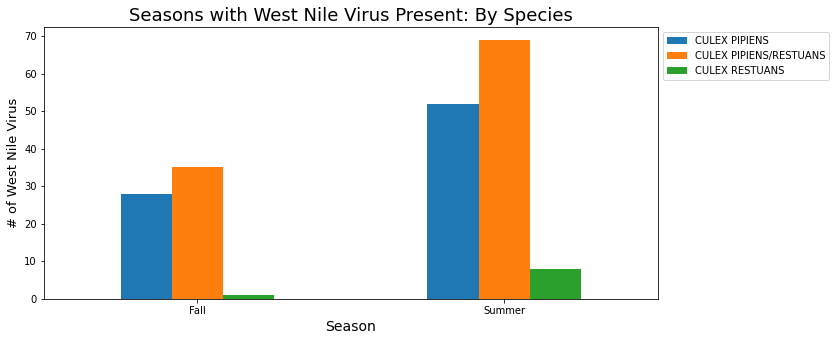

In [121]:
VirusSeason=new_df[new_df['WnvPresent']==1].groupby(['Season'])['Species'].value_counts().unstack().fillna(0)
VirusSeason.plot.bar(figsize=(11,5))
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), fontsize='medium')
plt.xlabel('Season', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('# of West Nile Virus', fontsize=13)
plt.title('Seasons with West Nile Virus Present: By Species', fontsize=18, color='black')
plt.show()

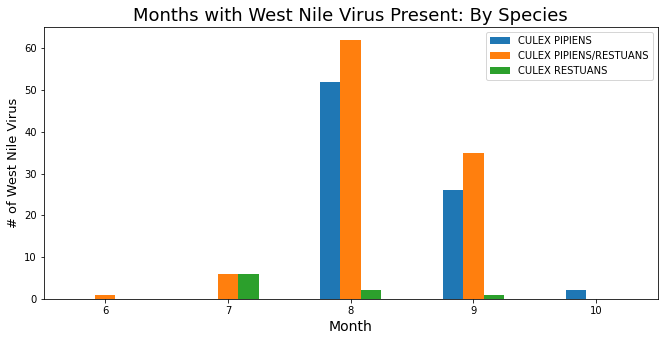

In [122]:
VirusSeason=new_df[new_df['WnvPresent']==1].groupby(['Month'])['Species'].value_counts().unstack().fillna(0)
VirusSeason.plot.bar(figsize=(11,5))
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), fontsize='medium')
plt.xlabel('Month', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('# of West Nile Virus', fontsize=13)
plt.title('Months with West Nile Virus Present: By Species', fontsize=18, color='black')
plt.show()

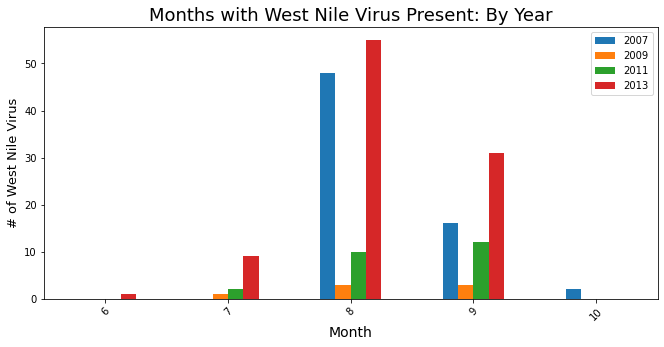

In [123]:
VirusSeason=new_df[new_df['WnvPresent']==1].groupby(['Month'])['Year'].value_counts().unstack().fillna(0)
VirusSeason.plot.bar(figsize=(11,5))
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), fontsize='medium')
plt.xlabel('Month', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('# of West Nile Virus', fontsize=13)
plt.title('Months with West Nile Virus Present: By Year', fontsize=18, color='black')
plt.show()

In [124]:

new_df_scale = new_df.loc[:, ~new_df.columns.isin(['Address','Street','Trap','AddressNumberAndStreet','Season','Season_Year','CodeSum','MonthName','Date'])]

In [125]:
new_df_scale = new_df_scale.set_index('Species')
new_df_scale = new_df_scale.dropna()
new_df_index = new_df_scale.index
new_df_columns = new_df_scale.columns
new_df_scale.head()

,Block,Latitude_x,Longitude_x,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tmax,Tmin,Tavg,...,Cool_Shift2,Sunrise_Shift2,Sunset_Shift2,PrecipTotal_Shift2,StnPressure_Shift2,SeaLevel_Shift2,ResultSpeed_Shift2,ResultDir_Shift2,AvgSpeed_Shift2,Relative_Humidity_Shift2
Species,,,,,,,,,,,,,,,,,,,,,
CULEX RESTUANS,52,41.778297,-87.752411,9,6,0,2,86,74,80.0,...,6.0,427.0,1928.0,0.00,29.44,30.09,4.1,8.0,5.4,54.99
CULEX PIPIENS,52,41.778297,-87.752411,9,5,0,2,84,70,77.0,...,13.0,419.0,1931.0,0.03,29.34,29.99,9.2,16.0,10.6,55.98
CULEX PIPIENS,52,41.778297,-87.752411,9,10,0,2,90,73,82.0,...,15.0,442.0,1915.0,0.36,29.34,29.96,3.5,4.0,5.6,69.25
CULEX PIPIENS/RESTUANS,52,41.778297,-87.752411,9,1,0,2,86,72,79.0,...,12.0,536.0,1755.0,0.00,29.21,29.87,7.8,16.0,10.0,68.92
CULEX PIPIENS,52,41.778297,-87.752411,9,4,0,2,91,71,81.0,...,17.0,438.0,1918.0,0.01,29.25,29.89,2.1,35.0,6.1,60.59


In [126]:
new_df_scale = scale(new_df_scale)

In [127]:
new_df_scaled = pd.DataFrame(new_df_scale, columns=new_df_columns)
new_df_scaled.head()

,Block,Latitude_x,Longitude_x,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tmax,Tmin,Tavg,...,Cool_Shift2,Sunrise_Shift2,Sunset_Shift2,PrecipTotal_Shift2,StnPressure_Shift2,SeaLevel_Shift2,ResultSpeed_Shift2,ResultDir_Shift2,AvgSpeed_Shift2,Relative_Humidity_Shift2
0,0.524471,-0.660731,-0.717522,0.786061,-0.162730,-0.208938,0.49939,0.578764,1.377235,0.978888,...,-0.409159,-0.907371,0.923159,-0.406882,1.149072,1.054312,-0.670527,-1.068023,-0.861886,-0.890170
1,0.524471,-0.660731,-0.717522,0.786061,-0.256738,-0.208938,0.49939,0.348506,0.866172,0.596158,...,0.779562,-1.074046,0.968016,-0.316123,0.325335,0.243343,1.088320,-0.199142,1.196961,-0.784112
2,0.524471,-0.660731,-0.717522,0.786061,0.213300,-0.208938,0.49939,1.039280,1.249469,1.234040,...,1.119197,-0.594855,0.728775,0.682228,0.325335,0.000053,-0.877450,-1.502464,-0.782699,0.637490
3,0.524471,-0.660731,-0.717522,0.786061,-0.632768,-0.208938,0.49939,0.578764,1.121703,0.851311,...,0.609745,1.363578,-1.663639,-0.406882,-0.745523,-0.729819,0.605499,-0.199142,0.959401,0.602138
4,0.524471,-0.660731,-0.717522,0.786061,-0.350745,-0.208938,0.49939,1.154408,0.993937,1.106464,...,1.458832,-0.678192,0.773633,-0.376629,-0.416028,-0.567626,-1.360271,1.864450,-0.584733,-0.290247


In [128]:
new_df_scaled.mean()

Block                      -3.764658e-17
Latitude_x                 -3.071781e-14
Longitude_x                 3.212399e-14
AddressAccuracy             1.246027e-14
NumMosquitos                5.072777e-16
                                ...     
SeaLevel_Shift2             3.502944e-14
ResultSpeed_Shift2          1.449498e-16
ResultDir_Shift2            1.641032e-17
AvgSpeed_Shift2            -4.836472e-18
Relative_Humidity_Shift2    1.102331e-15
Length: 76, dtype: float64

In [129]:
new_df_scaled.std()

Block                       1.000108
Latitude_x                  1.000108
Longitude_x                 1.000108
AddressAccuracy             1.000108
NumMosquitos                1.000108
                              ...   
SeaLevel_Shift2             1.000108
ResultSpeed_Shift2          1.000108
ResultDir_Shift2            1.000108
AvgSpeed_Shift2             1.000108
Relative_Humidity_Shift2    1.000108
Length: 76, dtype: float64

In [130]:
new_df_scaled.std(ddof=0)

Block                       1.0
Latitude_x                  1.0
Longitude_x                 1.0
AddressAccuracy             1.0
NumMosquitos                1.0
                           ... 
SeaLevel_Shift2             1.0
ResultSpeed_Shift2          1.0
ResultDir_Shift2            1.0
AvgSpeed_Shift2             1.0
Relative_Humidity_Shift2    1.0
Length: 76, dtype: float64

In [131]:
new_df_pca = PCA().fit(new_df_scale)

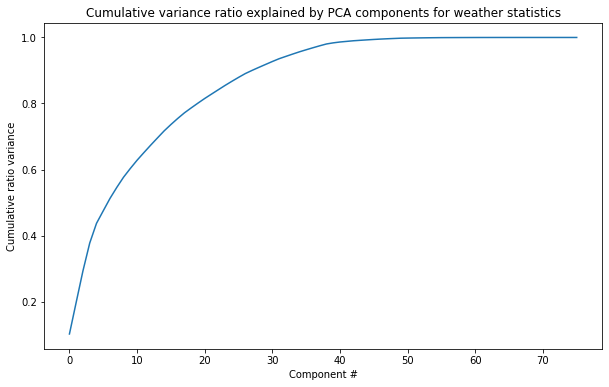

In [132]:
plt.subplots(figsize=(10, 6))
plt.plot(new_df_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for weather statistics');

In [133]:
new_df_pca_x = new_df_pca.transform(new_df_scale)

In [134]:
new_df_pca_x.shape

(4614, 76)

In [135]:
pca_df = pd.DataFrame({'PC1': new_df_pca_x[:, 0], 'PC2': new_df_pca_x[:, 1]}, index=new_df_index) 
pca_df.head()

,PC1,PC2
Species,,
CULEX RESTUANS,-0.252409,-1.886781
CULEX PIPIENS,-0.880491,-3.432842
CULEX PIPIENS,-2.602389,-3.821806
CULEX PIPIENS/RESTUANS,-1.124936,-4.013106
CULEX PIPIENS,-2.162876,-4.178528


[Text(0.5, 1.0, 'Presence of Virus by Species')]

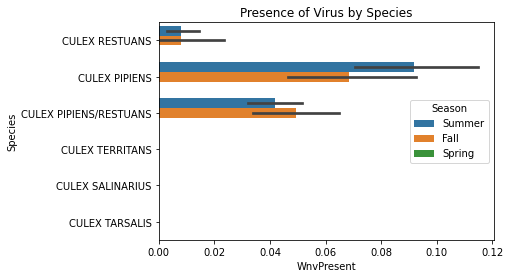

In [136]:
sns.barplot(data = new_df
            ,x = 'WnvPresent'
            ,y = 'Species',hue = 'Season'
            ).set(title='Presence of Virus by Species')

In [137]:
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop(columns='WnvPresent'), 
                                                    df_copy.WnvPresent, test_size=0.3, 
                                                    random_state=47)

In [138]:
# define a binning function

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [139]:
final_iv, IV = data_vars(X_train, y_train)

C:\Users\mayra\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mayra\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mayra\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mayra\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mayra\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mayra\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = geta

In [140]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(3229, 43)

,Address,AddressNumberAndStreet,AvgSpeed,Block,CodeSum,Cool_Shift1,CoorAvg,Depart,Depart_Shift2,DewPoint,...,Tavg_Shift1,Tmax_Shift2,Tmin,Tmin_Shift1,Trap,Week,WeekDay,WetBulb,WetBulb_Shift1,Year
3201,"2800 North Francisco Avenue, Chicago, IL 60618...","2800 N FRANCISCO AVE, Chicago, IL",7.1,28,TS TSRA RA BR,12.0,0.098988,4.0,3.0,69,...,77.0,85.0,72,69.0,T147,33,2,71.0,72.0,2007
5211,"7100 South South Shore Drive, Chicago, IL 6064...","7100 S SOUTH SHORE DR, Chicago, IL",6.0,71,,9.0,0.104454,-8.0,5.0,43,...,74.0,85.0,46,63.0,T079,37,2,50.0,63.0,2007
593,"2200 West 113th Street, Chicago, IL 60643, USA","2200 W 113TH ST, Chicago, IL",11.2,22,,12.0,0.086483,-3.0,5.0,51,...,77.0,85.0,63,72.0,T086,28,2,59.0,71.0,2007
14419,"8900 South Carpenter Street, Chicago, IL 60620...","8900 S CARPENTER ST, Chicago, IL",6.4,89,RA,1.0,0.077687,-6.0,-4.0,46,...,66.0,82.0,48,57.0,T159,38,4,51.0,58.0,2011
8249,"2500 South Millard Avenue, Chicago, IL 60623, USA","2500 S MILLARD AVE, Chicago, IL",10.4,25,RA,14.0,0.047899,-10.0,-3.0,52,...,79.0,71.0,58,66.0,T152,29,4,57.0,69.0,2009


In [141]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1


C:\Users\mayra\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Latitude_y with VIF of inf
Iteration # 2
Removing Longitude_y with VIF of 35520097.505424
Iteration # 3
Removing Longitude_x with VIF of 1518127.376583
Iteration # 4
Removing Year with VIF of 432146.060134
Iteration # 5
Removing Latitude_x with VIF of 157254.316276
Iteration # 6
Removing SeaLevel with VIF of 51641.127211
Iteration # 7
Removing SeaLevel_Shift2 with VIF of 23385.722717
Iteration # 8
Removing WetBulb with VIF of 13529.930819
Iteration # 9
Removing WetBulb_Shift1 with VIF of 11508.164697
Iteration # 10
Removing DewPoint with VIF of 2046.484784
Iteration # 11
Removing Sunrise with VIF of 1552.073768
Iteration # 12
Removing Tavg_Shift1 with VIF of 1335.637480
Iteration # 13
Removing Station_Shift1 with VIF of 795.198175
Iteration # 14
Removing Sunset with VIF of 688.443261
Iteration # 15
Removing Tmin_Shift1 with VIF of 523.324983
Iteration # 16
Removing Station with VIF of 211.280996
Iteration # 17
Removing Tmax_Shift2 with VIF of 185.823706
Iteration # 18
Removing

In [142]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

12

Index(['Block', 'Cool_Shift1', 'Depart', 'Depart_Shift2', 'Heat', 'LatDif',
       'MonthDay', 'ResultDir', 'ResultSpeed', 'SpeciesDummy_CULEX PIPIENS',
       'SpeciesDummy_CULEX RESTUANS', 'WeekDay'],
      dtype='object')

,Block,Cool_Shift1,Depart,Depart_Shift2,Heat,LatDif,MonthDay,ResultDir,ResultSpeed,SpeciesDummy_CULEX PIPIENS,SpeciesDummy_CULEX RESTUANS,WeekDay
3201,28,12.0,4.0,3.0,0.0,0.146094,15,6,4.9,0,0,2
5211,71,9.0,-8.0,5.0,9.0,0.019798,12,5,1.9,0,0,2
593,22,12.0,-3.0,5.0,0.0,0.097676,11,30,9.1,0,1,2
14419,89,1.0,-6.0,-4.0,10.0,0.053016,23,36,4.1,0,0,4
8249,25,14.0,-10.0,-3.0,1.0,0.060075,17,29,10.1,0,0,4


In [143]:
X_test=X_test[X_train.columns]
X_test.head()

,Block,Cool_Shift1,Depart,Depart_Shift2,Heat,LatDif,MonthDay,ResultDir,ResultSpeed,SpeciesDummy_CULEX PIPIENS,SpeciesDummy_CULEX RESTUANS,WeekDay
11969,24,11.0,5.0,-6.0,0.0,0.081428,15,10,6.2,0,0,4
9029,48,12.0,-4.0,14.0,0.0,0.139198,31,27,5.9,0,1,4
1339,11,12.0,3.0,3.0,0.0,0.082142,27,36,1.2,0,1,4
12111,50,0.0,7.0,10.0,0.0,0.015498,25,35,2.1,0,0,0
18787,30,0.0,7.0,10.0,0.0,0.071402,12,34,6.8,0,0,3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Features [0.1033099  0.08346916 0.1448451  0.10739833 0.01906739 0.10586609
 0.07205984 0.08720545 0.14021729 0.02332631 0.05738151 0.05585362]


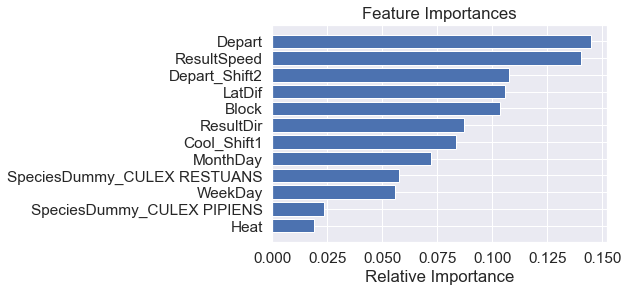

[[1329    2]
 [  52    2]]


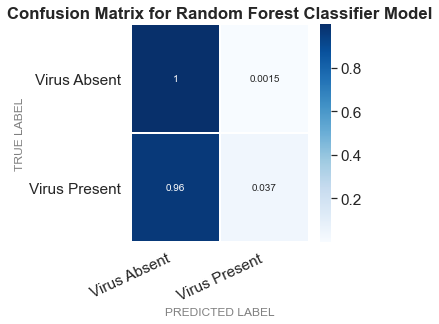

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:49, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)


print("Features",rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



roc1 = roc_auc_score(y_test, y_pred1)

roc1

#conf1 = confusion_matrix(y_test, y_pred1)
#conf1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, ['Virus Absent', 'Virus Present'], rotation=25)
plt.yticks(tick_marks2, ['Virus Absent', 'Virus Present'], rotation=0)
plt.xlabel('PREDICTED LABEL', fontsize=12, color='grey')
plt.ylabel('TRUE LABEL', fontsize=12, color='grey')
plt.title('Confusion Matrix for Random Forest Classifier Model',fontweight='bold')
plt.show()

In [145]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1331
           1       0.50      0.04      0.07        54

    accuracy                           0.96      1385
   macro avg       0.73      0.52      0.52      1385
weighted avg       0.94      0.96      0.94      1385



In [146]:
roc1

0.517767203717617

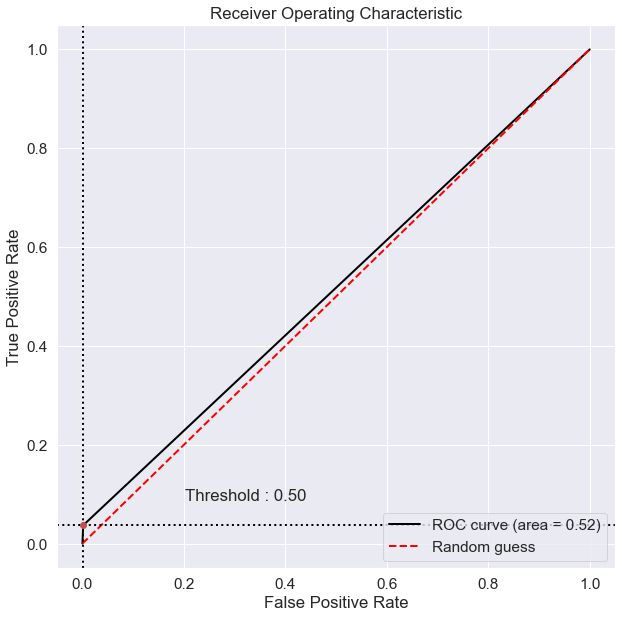

In [147]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred1, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()

In [148]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=0, n_jobs=-1, oob_score=True)
xgb.fit(X_train, y_train)

y_pred2 = xgb.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

C:\Users\mayra\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5581642875031305

[[1264   67]
 [  45    9]]


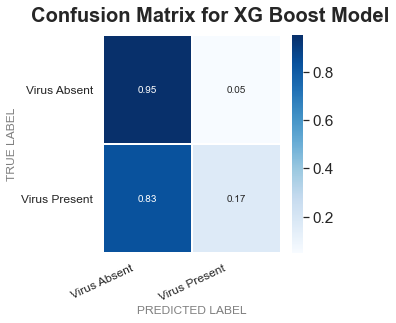

In [149]:
print(confusion_matrix(y_test, y_pred2))
matrix = confusion_matrix(y_test, y_pred2)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, ['Virus Absent', 'Virus Present'], rotation=25, fontsize = 12)
plt.yticks(tick_marks2, ['Virus Absent', 'Virus Present'], rotation=0, fontsize = 12)
plt.xlabel('PREDICTED LABEL', fontsize=12, color='grey')
plt.ylabel('TRUE LABEL', fontsize=12, color='grey')
plt.suptitle('Confusion Matrix for XG Boost Model',fontweight='bold')
plt.show()

In [150]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1331
           1       0.12      0.17      0.14        54

    accuracy                           0.92      1385
   macro avg       0.54      0.56      0.55      1385
weighted avg       0.93      0.92      0.93      1385



In [151]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 42)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.957
Accuracy score (validation): 0.961

Learning rate:  0.1
Accuracy score (training): 0.957
Accuracy score (validation): 0.961

Learning rate:  0.25
Accuracy score (training): 0.957
Accuracy score (validation): 0.958

Learning rate:  0.5
Accuracy score (training): 0.957
Accuracy score (validation): 0.960

Learning rate:  0.75
Accuracy score (training): 0.958
Accuracy score (validation): 0.957

Learning rate:  1
Accuracy score (training): 0.955
Accuracy score (validation): 0.952



In [152]:
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 1, max_features=2, max_depth = 2, random_state = 42).fit(X_train, y_train)
y_pred3 = gb.predict(X_test)
print(classification_report(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1331
           1       0.07      0.02      0.03        54

    accuracy                           0.95      1385
   macro avg       0.52      0.50      0.50      1385
weighted avg       0.93      0.95      0.94      1385

[[1318   13]
 [  53    1]]


In [153]:
roc3 = roc_auc_score(y_test, y_pred3)

roc3

0.504375713053399

0.504375713053399


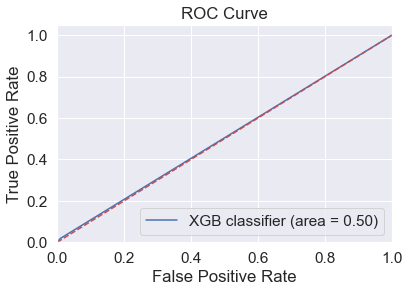

In [154]:
roc3 = roc_auc_score(y_test, y_pred3)
print(roc3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

plt.figure()
plt.plot(fpr, tpr, label='XGB classifier (area = %0.2f)' % roc3 )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [155]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
                       
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=0)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [156]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

model = XGBClassifier(n_jobs=-1, random_state = 42, verbosity=0)

In [157]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=6, scoring_fit='roc_auc')

C:\Users\mayra\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [158]:
print(model.best_score_)
print(model.best_params_)

0.7430807654425214
{'eta': 0.05, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 10, 'scale_pos_weight': 49}


In [159]:
xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=9,grow_policy='depthwise', scale_pos_weight=49, random_state = 42, verbosity=0)
xgb.fit(X_train, y_train)

y_pred4 = xgb.predict(X_test)

roc4 = roc_auc_score(y_test, y_pred4)

roc4

0.6993558171244122

0.6993558171244122


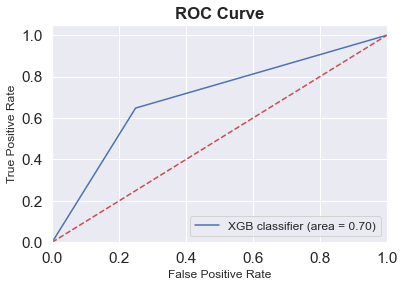

In [160]:
roc4 = roc_auc_score(y_test, y_pred4)
print(roc4)
fpr, tpr, thresholds = roc_curve(y_test, y_pred4)

plt.figure()
plt.plot(fpr, tpr, label='XGB classifier (area = %0.2f)' % roc4 )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('True Positive Rate',fontsize = 12)
plt.title('ROC Curve',fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.show()

[[999 332]
 [ 19  35]]


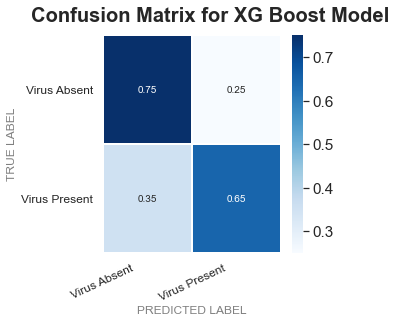

In [161]:
print(confusion_matrix(y_test, y_pred4))
matrix = confusion_matrix(y_test, y_pred4)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, ['Virus Absent', 'Virus Present'], rotation=25, fontsize = 12)
plt.yticks(tick_marks2, ['Virus Absent', 'Virus Present'], rotation=0, fontsize = 12)
plt.xlabel('PREDICTED LABEL', fontsize=12, color='grey')
plt.ylabel('TRUE LABEL', fontsize=12, color='grey')
plt.suptitle('Confusion Matrix for XG Boost Model',fontweight='bold')
plt.show()

In [162]:
xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=10,grow_policy='depthwise',scoring_fit='roc_auc', scale_pos_weight=49, n_jobs=-1, random_state = 42, verbosity=0)
xgb.fit(X_train, y_train)

y_pred5 = xgb.predict(X_test)

roc5 = roc_auc_score(y_test, y_pred5)

roc5

C:\Users\mayra\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6755989648551632

0.6755989648551632


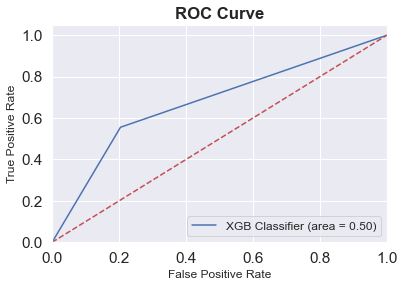

In [163]:
roc5 = roc_auc_score(y_test, y_pred5)
print(roc5)
fpr, tpr, thresholds = roc_curve(y_test, y_pred5)

plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc3 )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('ROC Curve', fontweight ='bold')
plt.legend(loc="lower right",fontsize=12)
plt.show()

[[1059  272]
 [  24   30]]


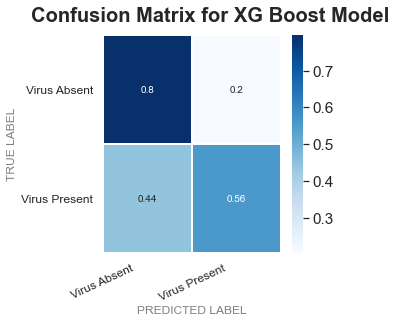

In [164]:
print(confusion_matrix(y_test, y_pred5))
matrix = confusion_matrix(y_test, y_pred5)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, ['Virus Absent', 'Virus Present'], rotation=25, fontsize = 12)
plt.yticks(tick_marks2, ['Virus Absent', 'Virus Present'], rotation=0, fontsize = 12)
plt.xlabel('PREDICTED LABEL', fontsize=12, color='grey')
plt.ylabel('TRUE LABEL', fontsize=12, color='grey')
plt.suptitle('Confusion Matrix for XG Boost Model',fontweight='bold')
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


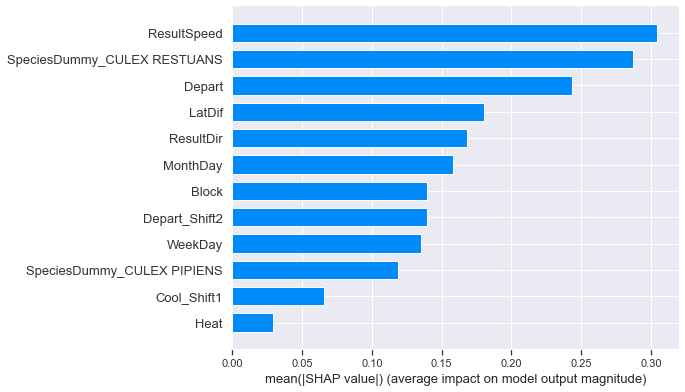

In [165]:
import shap
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

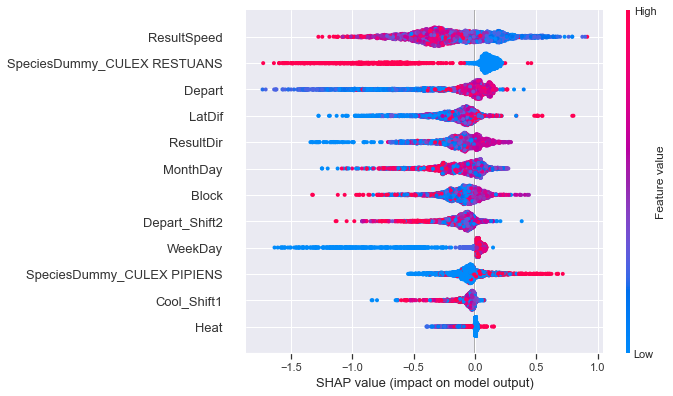

In [166]:
shap.summary_plot(shap_values, X_train)

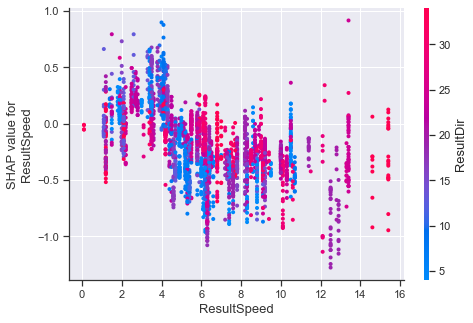

In [167]:
shap.dependence_plot("ResultSpeed", shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


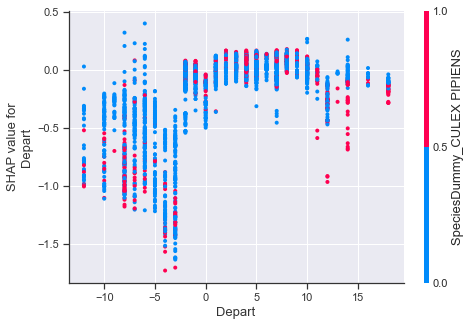

In [168]:
shap.dependence_plot("Depart", shap_values, X_train)

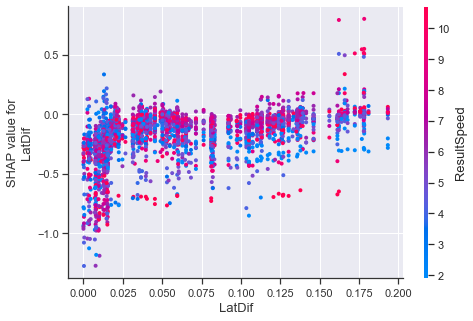

In [169]:
shap.dependence_plot("LatDif", shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


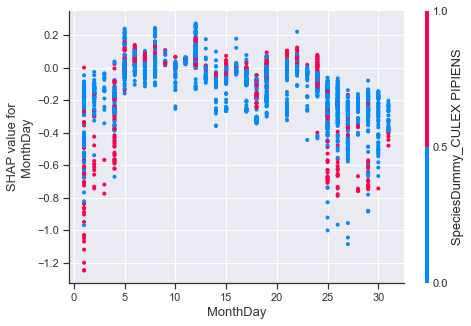

In [170]:
shap.dependence_plot("MonthDay", shap_values, X_train)